# DEMAND FORECASTING CASE STUDY

# Candidate Specifications:
### Name: Hammad Ahmed Hameed
### Email: hammadahmedhameed03@gmail.com
### Phone: +92 3035488017

## NOTE:
- **Demand Forecasting for both stores has been done separately.**
- **Answers to the questions asked in case study are given at the end of report for both stores separately.**

***------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------***

# Problem Statement:
#### --> Build a Forecasting model that would predict the future orders made by customers
**Reason for building the Model:**  
Many a times when a customer places an order, we have already ran out of the stock. Predicting the future orders will help us in taking necessary actions to keep the stock avaliable for future. This would help us earn  customer satisfaction and trust in the company.

# Hypothesis Generation:
Some of the assumptions that may affect orders are:   
**1- As the years pass by orders made by customers would increase.**  
- **Explanation:** Companies are always trying to improve and expanding their business so its obvious that the orders placed in latter years will be more compared to the past years.

**2- During Months that include Festivals like Eid, Chrismas or sales etc would result in greater orders.**
- **Explanation:** People buy more stock like cloths etc during such months.  

**3- Start of Months would result in more orders as compared to end of months.**
- **Explanation:** Since people get their pay during start of the month so they usually rush to stores for buying monthly household accessories.

**4- Their might by more orders at the weekends compared to weekdays.**
- **Explanation:** At weekend people are free thus they would buy their favourite accessories.

**5- More orders would be placed at evening times than at daytime.**
- **Explanation:** People are at homes at evening and nights and not in offices doing work. This time would suit them for buying porducts.

### We would test all these assumptions in exploratory data analysis part of our project.

# Loading in Libraries and Data

In [445]:
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 14, 6
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA

import warnings
warnings.filterwarnings('ignore')

In [446]:
df = pd.read_csv('C:/Users/hamma/Desktop/AIRLIFT/Data Analyst -- Case Study -- Data.csv')
df.dtypes

warehouse       object
date            object
total_orders     int64
dtype: object

In [447]:
df.date = pd.to_datetime(df.date, format="%d/%m/%Y")
df.dtypes

warehouse               object
date            datetime64[ns]
total_orders             int64
dtype: object

In [448]:
df.isnull().sum()

warehouse       0
date            0
total_orders    0
dtype: int64

In [449]:
df

,warehouse,date,total_orders
0,EW1,2021-08-10,455
1,EW1,2021-08-11,553
2,EW1,2021-08-12,569
3,EW1,2021-08-13,426
4,EW1,2021-08-14,536
...,...,...,...
140,EW2,2021-11-04,1490
141,EW2,2021-11-05,1067
142,EW2,2021-11-06,1591
143,EW2,2021-11-07,1696


**Since the date column consists of date part only and the year is 2021 only, so we would be able to extract only months and days from the existing date columns.**

In [450]:
df['day'] = df['date'].dt.day
df['weekend'] = df['date'].dt.dayofweek.apply(lambda x: 1 if x in (5, 6) else 0) # i.e. 1: WeekDay, 0: WeekEnd
df['month'] = df['date'].dt.month
df

,warehouse,date,total_orders,day,weekend,month
0,EW1,2021-08-10,455,10,0,8
1,EW1,2021-08-11,553,11,0,8
2,EW1,2021-08-12,569,12,0,8
3,EW1,2021-08-13,426,13,0,8
4,EW1,2021-08-14,536,14,1,8
...,...,...,...,...,...,...
140,EW2,2021-11-04,1490,4,0,11
141,EW2,2021-11-05,1067,5,0,11
142,EW2,2021-11-06,1591,6,1,11
143,EW2,2021-11-07,1696,7,1,11


In [451]:
total_orders = df.pop('total_orders')
df.insert(5, 'total_orders', total_orders)
df

,warehouse,date,day,weekend,month,total_orders
0,EW1,2021-08-10,10,0,8,455
1,EW1,2021-08-11,11,0,8,553
2,EW1,2021-08-12,12,0,8,569
3,EW1,2021-08-13,13,0,8,426
4,EW1,2021-08-14,14,1,8,536
...,...,...,...,...,...,...
140,EW2,2021-11-04,4,0,11,1490
141,EW2,2021-11-05,5,0,11,1067
142,EW2,2021-11-06,6,1,11,1591
143,EW2,2021-11-07,7,1,11,1696


In [452]:
ew1 = df[df['warehouse'] == 'EW1'].drop('warehouse', axis=1).set_index('date')
ew1.head()

,day,weekend,month,total_orders
date,,,,
2021-08-10,10,0,8,455
2021-08-11,11,0,8,553
2021-08-12,12,0,8,569
2021-08-13,13,0,8,426
2021-08-14,14,1,8,536


In [453]:
ew2 = df[df['warehouse'] == 'EW2'].drop('warehouse', axis=1).set_index('date')
ew2.head()

,day,weekend,month,total_orders
date,,,,
2021-09-15,15,0,9,186
2021-09-16,16,0,9,199
2021-09-17,17,0,9,326
2021-09-18,18,1,9,390
2021-09-19,19,1,9,353


**Now we will analysis as well as prediction for the two stores one by one.**

# Exploratory Data Analysis For EW1

In [454]:
ew1

,day,weekend,month,total_orders
date,,,,
2021-08-10,10,0,8,455
2021-08-11,11,0,8,553
2021-08-12,12,0,8,569
2021-08-13,13,0,8,426
2021-08-14,14,1,8,536
...,...,...,...,...
2021-11-04,4,0,11,386
2021-11-05,5,0,11,375
2021-11-06,6,1,11,441


<AxesSubplot:xlabel='day'>

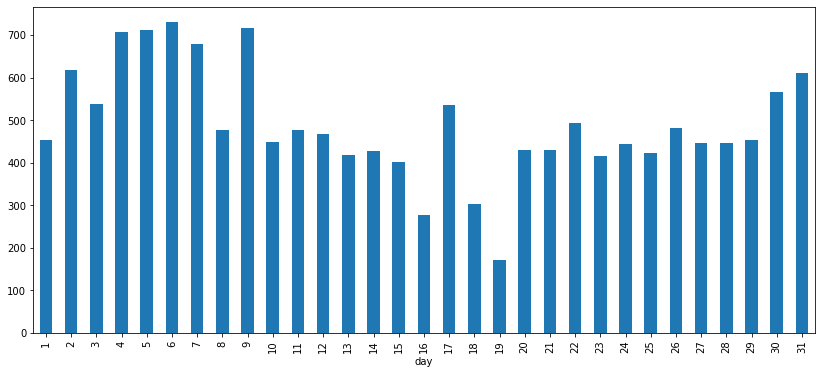

In [455]:
ew1.groupby('day')['total_orders'].mean().plot.bar()

<AxesSubplot:xlabel='weekend'>

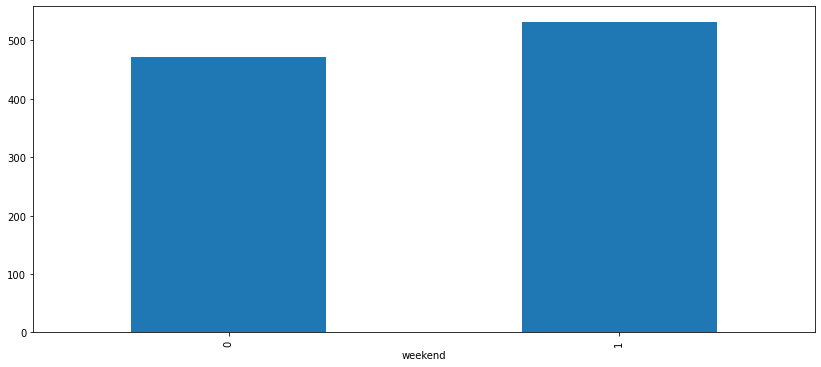

In [456]:
ew1.groupby('weekend')['total_orders'].mean().plot.bar()

<AxesSubplot:xlabel='month'>

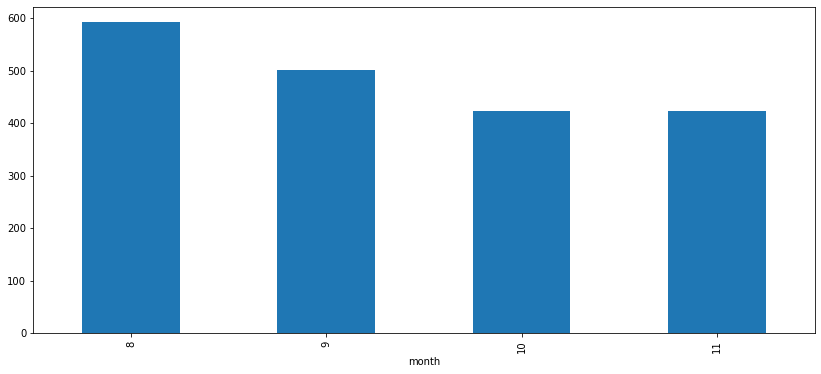

In [457]:
ew1.groupby('month')['total_orders'].mean().plot.bar()

# Observations:
- **Our generated hypothesis that more orders at start of month seems correct.**
- **Visualz also show more orders at weekends than weekdays.**
- **There is a drop in orders as months pass by.**

# Forecasting For EW1

In [458]:
ew1_backup = ew1.copy()

In [459]:
ew1.drop(['day', 'weekend', 'month'], axis=1, inplace=True)
ew1

,total_orders
date,
2021-08-10,455
2021-08-11,553
2021-08-12,569
2021-08-13,426
2021-08-14,536
...,...
2021-11-04,386
2021-11-05,375
2021-11-06,441


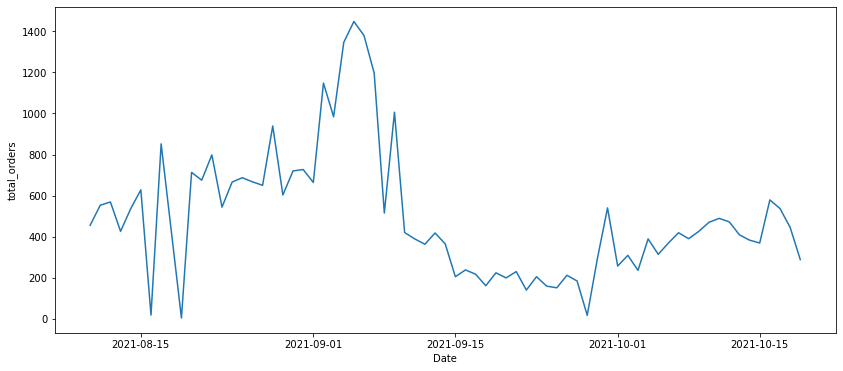

In [460]:
plt.xlabel('Date')
plt.ylabel('total_orders')
plt.plot(trainew1)

# Staitonarity

Our observations show that data is highly NON stationary. It does not have constant mean over time. It does not have constant variance over time. Also there is no clear trend and no clear seasonality. The results show that we are exhibiting more of a random walk pattern. So the best approch for removing this type of non stationarity is by differencing.

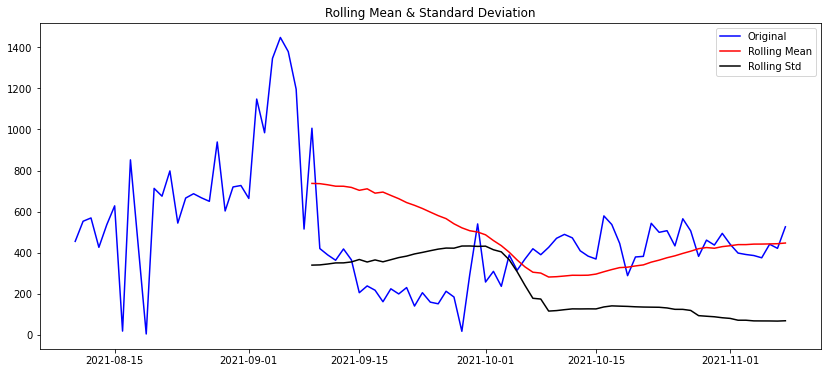

Results of Dickey-Fuller Test:
Test Statistic                 -2.067937
p-value                         0.257601
#Lags Used                      1.000000
Number of Observations Used    88.000000
Critical Value (1%)            -3.506944
Critical Value (5%)            -2.894990
Critical Value (10%)           -2.584615
dtype: float64


In [461]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(30).mean()
    rolstd = timeseries.rolling(30).std()
    
    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
test_stationarity(ew1)

A greater p-val gives support to Null hypothesis that data is not stationary.
So to make data stationary we need to remove any trend and any seasonality from the series.

## Making time series stationary

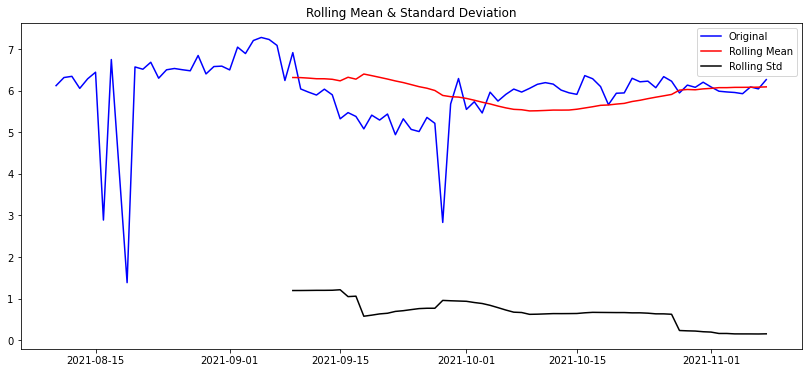

Results of Dickey-Fuller Test:
Test Statistic                 -2.962117
p-value                         0.038587
#Lags Used                      2.000000
Number of Observations Used    87.000000
Critical Value (1%)            -3.507853
Critical Value (5%)            -2.895382
Critical Value (10%)           -2.584824
dtype: float64


In [462]:
ew1log = np.log(ew1['total_orders'])

test_stationarity(ew1log.dropna())

In [463]:
ew1log_diff = ew1log - ew1log.shift(1)

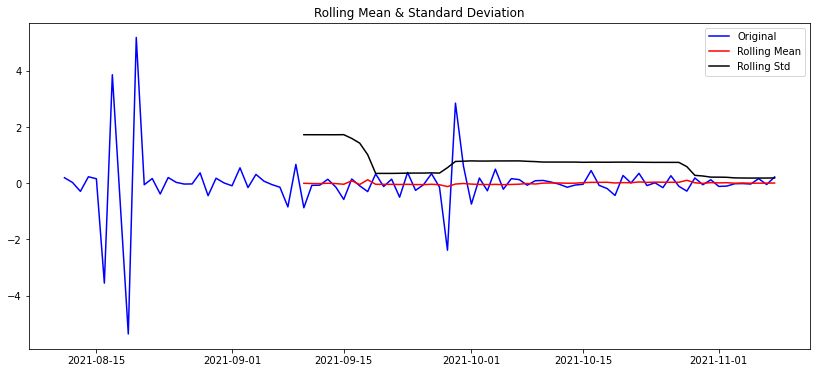

Results of Dickey-Fuller Test:
Test Statistic                -1.049545e+01
p-value                        1.118603e-18
#Lags Used                     1.000000e+00
Number of Observations Used    8.700000e+01
Critical Value (1%)           -3.507853e+00
Critical Value (5%)           -2.895382e+00
Critical Value (10%)          -2.584824e+00
dtype: float64


In [464]:
test_stationarity(ew1log_diff.dropna())

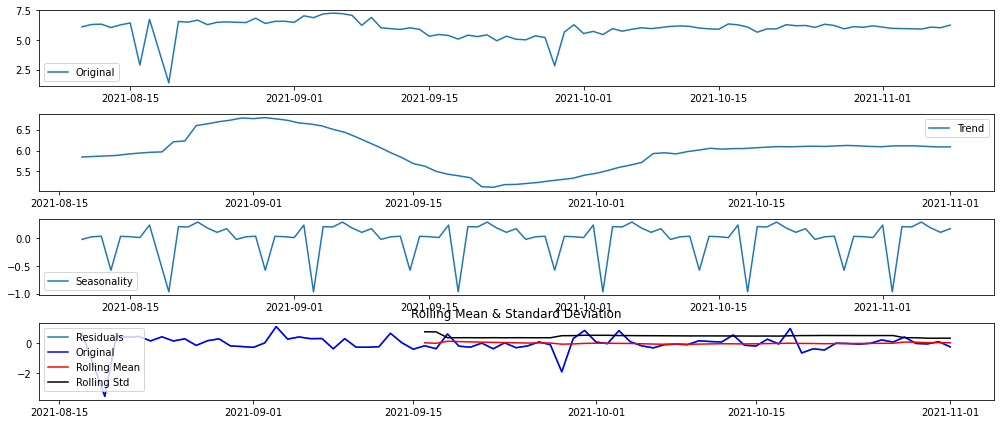

Results of Dickey-Fuller Test:
Test Statistic                -9.869532e+00
p-value                        4.029312e-17
#Lags Used                     0.000000e+00
Number of Observations Used    7.500000e+01
Critical Value (1%)           -3.520713e+00
Critical Value (5%)           -2.900925e+00
Critical Value (10%)          -2.587781e+00
dtype: float64


In [465]:
decomposition = seasonal_decompose(ew1log, freq=15)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ew1log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()


ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

The test statistics and p-value clearly reject Null hypothesis for residuals. Thus we can say that residuals are stationary. Now lets try models.

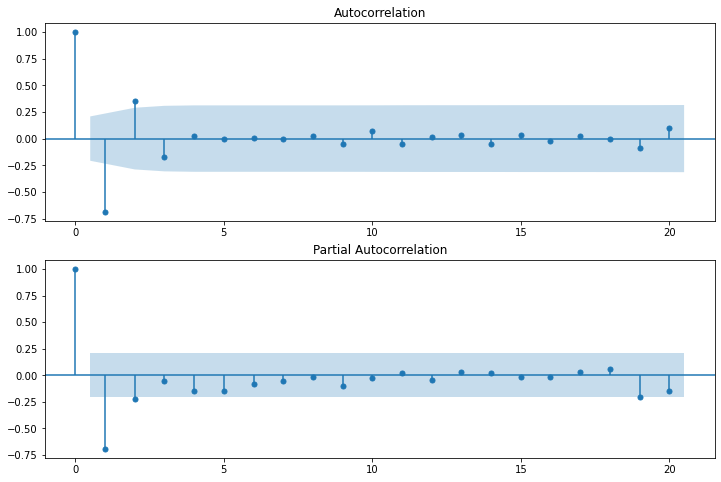

In [466]:
fig = plt.figure(figsize=(12, 8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ew1log_diff.dropna(), lags=20, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ew1log_diff.dropna(), lags=20, ax=ax2)

**Determining values of p, d, q for ARIMA model using ACF AND PACF**  
 p = 1  
 d = 1  
 q = 1

# Using ARIMA

date
2021-08-11   -0.000921
2021-08-12   -0.132612
2021-08-13   -0.075764
2021-08-14    0.219653
2021-08-15   -0.111974
dtype: float64
date
2021-08-11   -0.000921
2021-08-12   -0.133533
2021-08-13   -0.209297
2021-08-14    0.010356
2021-08-15   -0.101619
dtype: float64


(array([6.06364769, 6.15580017, 6.11172364, 6.13081241, 6.12061333,
        6.12399414, 6.12107836]),
 array([0.76281509, 0.76873465, 0.86878361, 0.9072092 , 0.96460912,
        1.00927518, 1.05617387]),
 array([[4.56855759, 7.55873779],
        [4.64910794, 7.6624924 ],
        [4.40893905, 7.81450824],
        [4.35271506, 7.90890976],
        [4.23001418, 8.01121247],
        [4.14585113, 8.10213715],
        [4.05101563, 8.1911411 ]]))

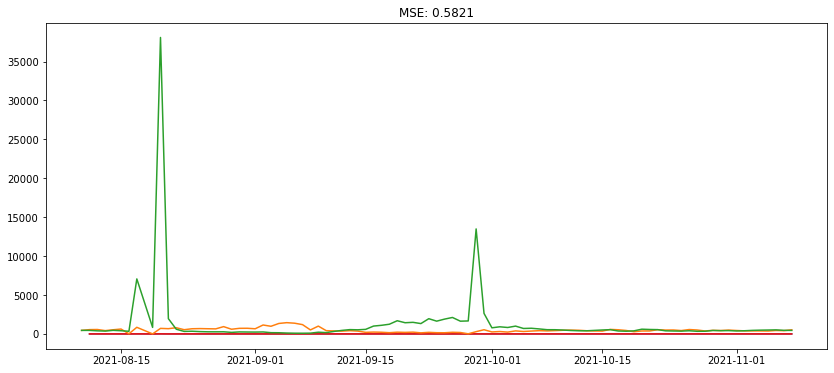

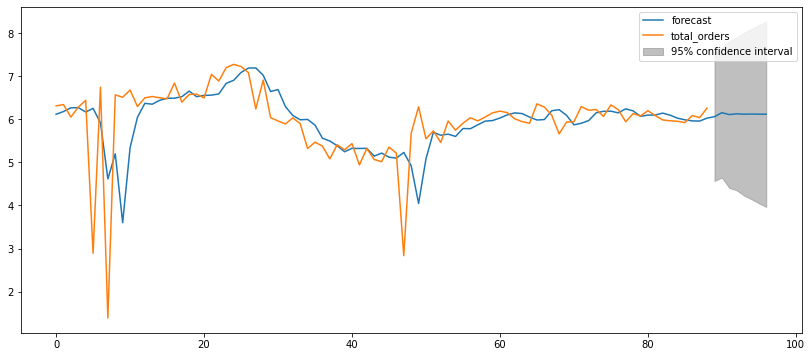

In [467]:
# fitting ARIMA model
model = ARIMA(ew1log, order=(1, 1, 1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(ew1log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('MSE: %.4f'% np.mean((results_ARIMA.fittedvalues-ew1log_diff)**2))

# taking back to original scale
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print(predictions_ARIMA_diff_cumsum.head())

predictions_ARIMA_log = pd.Series(ew1log[0], index=ew1log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ew1)
plt.plot(predictions_ARIMA)

results_ARIMA.plot_predict(1, 97)
results_ARIMA.forecast(steps=7)